[CartPole Game](https://gym.openai.com/envs/CartPole-v0)  [Description](https://github.com/openai/gym/wiki/CartPole-v0)   

In [1]:
import numpy as np
import pickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import gym
env = gym.make('CartPole-v0')

[2017-04-17 16:46:25,247] Making new env: CartPole-v0


In [3]:
# hyperparameters
H = 10 # number of hidden layer neurons
batch_size = 5 # every how many episodes to do a param update?
learning_rate = 1e-2 # feel free to play with this to train faster or more stably.
gamma = 0.99 # discount factor for reward

D = 4 # input dimensionality

In [4]:
tf.reset_default_graph()

#This defines the network as it goes from taking an observation of the environment to 
#giving a probability of chosing to the action of moving left or right.
observations = tf.placeholder(tf.float32, [None,D] , name="input_x")
W1 = tf.get_variable("W1", shape=[D, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
# Create a summary to visualize the first layer activation
tf.summary.histogram("layer1", layer1)
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
# Create another summary to visualize the second layer
tf.summary.histogram("layer2", score)
probability = tf.nn.sigmoid(score)

#From here we define the parts of the network needed for learning a good policy.
tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")

# The loss function. This sends the weights in the direction of making actions 
# that gave good advantage (reward over time) more likely, and actions that didn't less likely.
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
with tf.name_scope('Loss'):
    loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)

# Once we have collected a series of gradients from multiple episodes, we apply them.
# We don't just apply gradeients after every episode in order to account for noise in the reward signal.
with tf.name_scope('Adam'):
    adam = tf.train.AdamOptimizer(learning_rate=learning_rate) # Our optimizer
    W1Grad = tf.placeholder(tf.float32,name="batch_grad1") # Placeholders to send the final gradients through when we update.
    W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
    batchGrad = [W1Grad,W2Grad]
    updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

In [5]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [6]:
xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
total_episodes = 10000
max_reward = 200
logs_path = '/tmp/tensorflow_logs/policy'
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
episodes = []
episodic_rewards = []
total_rewards = []

In [7]:
zipped_grads = list(zip(newGrads, tf.trainable_variables()))
# Create summaries to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
# Summarize all gradients
for grad, var in zipped_grads:
    tf.summary.histogram(var.name + '/gradient', grad)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

INFO:tensorflow:Summary name W1:0 is illegal; using W1_0 instead.


[2017-04-17 16:46:31,159] Summary name W1:0 is illegal; using W1_0 instead.


INFO:tensorflow:Summary name W2:0 is illegal; using W2_0 instead.


[2017-04-17 16:46:31,169] Summary name W2:0 is illegal; using W2_0 instead.


INFO:tensorflow:Summary name W1:0/gradient is illegal; using W1_0/gradient instead.


[2017-04-17 16:46:31,174] Summary name W1:0/gradient is illegal; using W1_0/gradient instead.


INFO:tensorflow:Summary name W2:0/gradient is illegal; using W2_0/gradient instead.


[2017-04-17 16:46:31,180] Summary name W2:0/gradient is illegal; using W2_0/gradient instead.


In [8]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path,graph=tf.get_default_graph())
    # Obtain an initial observation of the environment
    observation = env.reset() 
    # Reset the gradient placeholder. We will collect gradients in 
    # gradBuffer until we are ready to update our policy network. 
    gradBuffer = sess.run(tvars)
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while (episode_number <= total_episodes):
        # Make sure the observation is in a shape the network can handle.
        x = np.reshape(observation,[1,D])
        # Run the policy network and get an action to take. 
        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0
        
        xs.append(x) # observation
        y = 1 if action == 0 else 0 # a "fake label"
        ys.append(y)

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward

        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            episode_number += 1
            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            tfp = tfps
            xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[] # reset array memory

            # compute the discounted reward backwards through time
            discounted_epr = discount_rewards(epr)
            # size the rewards to be unit normal (helps control the gradient estimator variance)
            discounted_epr -= np.mean(discounted_epr)
            discounted_epr /= np.std(discounted_epr)
            
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            # Get the gradient for this episode, and save it in the gradBuffer
            tGrad,summary = sess.run([newGrads,merged_summary_op],feed_dict={observations: epx, input_y: epy, advantages: discounted_epr},options=run_options)
            # Write logs at every iteration
            summary_writer.add_run_metadata(run_metadata, 'step%03d' % episode_number)
            summary_writer.add_summary(summary, episode_number)
            for ix,grad in enumerate(tGrad):
                gradBuffer[ix] += grad
                
            # If we have completed enough episodes, then update the policy network with our gradients.
            if episode_number % batch_size == 0: 
                sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})    
                for ix,grad in enumerate(gradBuffer):
                    gradBuffer[ix] = grad * 0
                
                # Give a summary of how well our network is doing for each batch of episodes.
                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                print ('Episode %d - Average reward: %f,Total average reward: %f.' % (episode_number,reward_sum/batch_size, running_reward/batch_size))
                episodes.append(episode_number)
                episodic_rewards.append(reward_sum/batch_size)
                total_rewards.append(running_reward/batch_size)
                if running_reward/batch_size >= max_reward: 
                    print('Task solved in {} episodes!"'.format(episode_number))
                    break
                    
                reward_sum = 0
            
            observation = env.reset()
        
print (episode_number-1,'Episodes completed.')
print ('Final Reward',running_reward/batch_size)
summary_writer.close()

Episode 5 - Average reward: 19.200000,Total average reward: 19.200000.
Episode 10 - Average reward: 17.800000,Total average reward: 19.186000.
Episode 15 - Average reward: 25.400000,Total average reward: 19.248140.
Episode 20 - Average reward: 22.400000,Total average reward: 19.279659.
Episode 25 - Average reward: 24.600000,Total average reward: 19.332862.
Episode 30 - Average reward: 21.000000,Total average reward: 19.349533.
Episode 35 - Average reward: 23.400000,Total average reward: 19.390038.
Episode 40 - Average reward: 13.800000,Total average reward: 19.334138.
Episode 45 - Average reward: 23.800000,Total average reward: 19.378796.
Episode 50 - Average reward: 19.000000,Total average reward: 19.375008.
Episode 55 - Average reward: 15.200000,Total average reward: 19.333258.
Episode 60 - Average reward: 18.800000,Total average reward: 19.327926.
Episode 65 - Average reward: 18.400000,Total average reward: 19.318646.
Episode 70 - Average reward: 18.800000,Total average reward: 19.3

Episode 570 - Average reward: 45.000000,Total average reward: 33.406509.
Episode 575 - Average reward: 75.000000,Total average reward: 33.822444.
Episode 580 - Average reward: 48.600000,Total average reward: 33.970219.
Episode 585 - Average reward: 51.600000,Total average reward: 34.146517.
Episode 590 - Average reward: 53.600000,Total average reward: 34.341052.
Episode 595 - Average reward: 60.000000,Total average reward: 34.597641.
Episode 600 - Average reward: 63.000000,Total average reward: 34.881665.
Episode 605 - Average reward: 93.800000,Total average reward: 35.470848.
Episode 610 - Average reward: 77.600000,Total average reward: 35.892140.
Episode 615 - Average reward: 52.200000,Total average reward: 36.055218.
Episode 620 - Average reward: 46.000000,Total average reward: 36.154666.
Episode 625 - Average reward: 45.000000,Total average reward: 36.243120.
Episode 630 - Average reward: 77.000000,Total average reward: 36.650688.
Episode 635 - Average reward: 58.800000,Total avera

Episode 1125 - Average reward: 190.800000,Total average reward: 110.688159.
Episode 1130 - Average reward: 184.200000,Total average reward: 111.423278.
Episode 1135 - Average reward: 192.800000,Total average reward: 112.237045.
Episode 1140 - Average reward: 199.200000,Total average reward: 113.106674.
Episode 1145 - Average reward: 185.000000,Total average reward: 113.825608.
Episode 1150 - Average reward: 200.000000,Total average reward: 114.687352.
Episode 1155 - Average reward: 179.400000,Total average reward: 115.334478.
Episode 1160 - Average reward: 174.200000,Total average reward: 115.923133.
Episode 1165 - Average reward: 195.200000,Total average reward: 116.715902.
Episode 1170 - Average reward: 188.600000,Total average reward: 117.434743.
Episode 1175 - Average reward: 193.000000,Total average reward: 118.190396.
Episode 1180 - Average reward: 166.000000,Total average reward: 118.668492.
Episode 1185 - Average reward: 195.600000,Total average reward: 119.437807.
Episode 1190

Episode 1665 - Average reward: 194.800000,Total average reward: 158.892128.
Episode 1670 - Average reward: 200.000000,Total average reward: 159.303206.
Episode 1675 - Average reward: 200.000000,Total average reward: 159.710174.
Episode 1680 - Average reward: 182.200000,Total average reward: 159.935073.
Episode 1685 - Average reward: 183.400000,Total average reward: 160.169722.
Episode 1690 - Average reward: 196.600000,Total average reward: 160.534025.
Episode 1695 - Average reward: 196.000000,Total average reward: 160.888684.
Episode 1700 - Average reward: 200.000000,Total average reward: 161.279797.
Episode 1705 - Average reward: 192.800000,Total average reward: 161.595000.
Episode 1710 - Average reward: 200.000000,Total average reward: 161.979050.
Episode 1715 - Average reward: 194.400000,Total average reward: 162.303259.
Episode 1720 - Average reward: 200.000000,Total average reward: 162.680226.
Episode 1725 - Average reward: 200.000000,Total average reward: 163.053424.
Episode 1730

Episode 2205 - Average reward: 200.000000,Total average reward: 183.331699.
Episode 2210 - Average reward: 194.200000,Total average reward: 183.440382.
Episode 2215 - Average reward: 198.000000,Total average reward: 183.585979.
Episode 2220 - Average reward: 200.000000,Total average reward: 183.750119.
Episode 2225 - Average reward: 194.200000,Total average reward: 183.854618.
Episode 2230 - Average reward: 193.800000,Total average reward: 183.954071.
Episode 2235 - Average reward: 196.200000,Total average reward: 184.076531.
Episode 2240 - Average reward: 200.000000,Total average reward: 184.235765.
Episode 2245 - Average reward: 191.600000,Total average reward: 184.309408.
Episode 2250 - Average reward: 184.200000,Total average reward: 184.308314.
Episode 2255 - Average reward: 193.000000,Total average reward: 184.395231.
Episode 2260 - Average reward: 189.000000,Total average reward: 184.441278.
Episode 2265 - Average reward: 190.400000,Total average reward: 184.500865.
Episode 2270

Episode 2745 - Average reward: 189.200000,Total average reward: 191.257205.
Episode 2750 - Average reward: 200.000000,Total average reward: 191.344633.
Episode 2755 - Average reward: 200.000000,Total average reward: 191.431186.
Episode 2760 - Average reward: 190.400000,Total average reward: 191.420875.
Episode 2765 - Average reward: 189.800000,Total average reward: 191.404666.
Episode 2770 - Average reward: 181.400000,Total average reward: 191.304619.
Episode 2775 - Average reward: 193.600000,Total average reward: 191.327573.
Episode 2780 - Average reward: 182.400000,Total average reward: 191.238297.
Episode 2785 - Average reward: 192.000000,Total average reward: 191.245914.
Episode 2790 - Average reward: 187.200000,Total average reward: 191.205455.
Episode 2795 - Average reward: 177.800000,Total average reward: 191.071401.
Episode 2800 - Average reward: 200.000000,Total average reward: 191.160687.
Episode 2805 - Average reward: 157.800000,Total average reward: 190.827080.
Episode 2810

Episode 3285 - Average reward: 185.200000,Total average reward: 191.237343.
Episode 3290 - Average reward: 181.200000,Total average reward: 191.136969.
Episode 3295 - Average reward: 200.000000,Total average reward: 191.225599.
Episode 3300 - Average reward: 185.200000,Total average reward: 191.165343.
Episode 3305 - Average reward: 190.000000,Total average reward: 191.153690.
Episode 3310 - Average reward: 199.000000,Total average reward: 191.232153.
Episode 3315 - Average reward: 200.000000,Total average reward: 191.319832.
Episode 3320 - Average reward: 200.000000,Total average reward: 191.406633.
Episode 3325 - Average reward: 175.200000,Total average reward: 191.244567.
Episode 3330 - Average reward: 194.000000,Total average reward: 191.272121.
Episode 3335 - Average reward: 200.000000,Total average reward: 191.359400.
Episode 3340 - Average reward: 180.800000,Total average reward: 191.253806.
Episode 3345 - Average reward: 200.000000,Total average reward: 191.341268.
Episode 3350

Episode 3825 - Average reward: 200.000000,Total average reward: 195.664147.
Episode 3830 - Average reward: 200.000000,Total average reward: 195.707506.
Episode 3835 - Average reward: 200.000000,Total average reward: 195.750431.
Episode 3840 - Average reward: 200.000000,Total average reward: 195.792926.
Episode 3845 - Average reward: 200.000000,Total average reward: 195.834997.
Episode 3850 - Average reward: 200.000000,Total average reward: 195.876647.
Episode 3855 - Average reward: 200.000000,Total average reward: 195.917881.
Episode 3860 - Average reward: 200.000000,Total average reward: 195.958702.
Episode 3865 - Average reward: 200.000000,Total average reward: 195.999115.
Episode 3870 - Average reward: 200.000000,Total average reward: 196.039124.
Episode 3875 - Average reward: 200.000000,Total average reward: 196.078732.
Episode 3880 - Average reward: 200.000000,Total average reward: 196.117945.
Episode 3885 - Average reward: 200.000000,Total average reward: 196.156766.
Episode 3890

Episode 4365 - Average reward: 200.000000,Total average reward: 196.502525.
Episode 4370 - Average reward: 200.000000,Total average reward: 196.537499.
Episode 4375 - Average reward: 200.000000,Total average reward: 196.572124.
Episode 4380 - Average reward: 200.000000,Total average reward: 196.606403.
Episode 4385 - Average reward: 200.000000,Total average reward: 196.640339.
Episode 4390 - Average reward: 200.000000,Total average reward: 196.673936.
Episode 4395 - Average reward: 200.000000,Total average reward: 196.707196.
Episode 4400 - Average reward: 200.000000,Total average reward: 196.740124.
Episode 4405 - Average reward: 200.000000,Total average reward: 196.772723.
Episode 4410 - Average reward: 200.000000,Total average reward: 196.804996.
Episode 4415 - Average reward: 200.000000,Total average reward: 196.836946.
Episode 4420 - Average reward: 200.000000,Total average reward: 196.868577.
Episode 4425 - Average reward: 200.000000,Total average reward: 196.899891.
Episode 4430

Episode 4905 - Average reward: 200.000000,Total average reward: 198.439742.
Episode 4910 - Average reward: 200.000000,Total average reward: 198.455344.
Episode 4915 - Average reward: 200.000000,Total average reward: 198.470791.
Episode 4920 - Average reward: 200.000000,Total average reward: 198.486083.
Episode 4925 - Average reward: 200.000000,Total average reward: 198.501222.
Episode 4930 - Average reward: 200.000000,Total average reward: 198.516210.
Episode 4935 - Average reward: 200.000000,Total average reward: 198.531048.
Episode 4940 - Average reward: 200.000000,Total average reward: 198.545737.
Episode 4945 - Average reward: 200.000000,Total average reward: 198.560280.
Episode 4950 - Average reward: 200.000000,Total average reward: 198.574677.
Episode 4955 - Average reward: 200.000000,Total average reward: 198.588931.
Episode 4960 - Average reward: 200.000000,Total average reward: 198.603041.
Episode 4965 - Average reward: 200.000000,Total average reward: 198.617011.
Episode 4970

Episode 5445 - Average reward: 200.000000,Total average reward: 198.419803.
Episode 5450 - Average reward: 200.000000,Total average reward: 198.435605.
Episode 5455 - Average reward: 200.000000,Total average reward: 198.451249.
Episode 5460 - Average reward: 200.000000,Total average reward: 198.466736.
Episode 5465 - Average reward: 200.000000,Total average reward: 198.482069.
Episode 5470 - Average reward: 200.000000,Total average reward: 198.497248.
Episode 5475 - Average reward: 200.000000,Total average reward: 198.512276.
Episode 5480 - Average reward: 200.000000,Total average reward: 198.527153.
Episode 5485 - Average reward: 200.000000,Total average reward: 198.541882.
Episode 5490 - Average reward: 200.000000,Total average reward: 198.556463.
Episode 5495 - Average reward: 200.000000,Total average reward: 198.570898.
Episode 5500 - Average reward: 200.000000,Total average reward: 198.585189.
Episode 5505 - Average reward: 200.000000,Total average reward: 198.599337.
Episode 5510

Episode 5985 - Average reward: 200.000000,Total average reward: 198.892752.
Episode 5990 - Average reward: 200.000000,Total average reward: 198.903825.
Episode 5995 - Average reward: 200.000000,Total average reward: 198.914787.
Episode 6000 - Average reward: 200.000000,Total average reward: 198.925639.
Episode 6005 - Average reward: 200.000000,Total average reward: 198.936382.
Episode 6010 - Average reward: 200.000000,Total average reward: 198.947019.
Episode 6015 - Average reward: 200.000000,Total average reward: 198.957548.
Episode 6020 - Average reward: 200.000000,Total average reward: 198.967973.
Episode 6025 - Average reward: 199.000000,Total average reward: 198.968293.
Episode 6030 - Average reward: 200.000000,Total average reward: 198.978610.
Episode 6035 - Average reward: 200.000000,Total average reward: 198.988824.
Episode 6040 - Average reward: 200.000000,Total average reward: 198.998936.
Episode 6045 - Average reward: 200.000000,Total average reward: 199.008947.
Episode 6050

Episode 6525 - Average reward: 181.400000,Total average reward: 199.287380.
Episode 6530 - Average reward: 200.000000,Total average reward: 199.294506.
Episode 6535 - Average reward: 200.000000,Total average reward: 199.301561.
Episode 6540 - Average reward: 200.000000,Total average reward: 199.308546.
Episode 6545 - Average reward: 200.000000,Total average reward: 199.315460.
Episode 6550 - Average reward: 200.000000,Total average reward: 199.322306.
Episode 6555 - Average reward: 200.000000,Total average reward: 199.329083.
Episode 6560 - Average reward: 200.000000,Total average reward: 199.335792.
Episode 6565 - Average reward: 200.000000,Total average reward: 199.342434.
Episode 6570 - Average reward: 200.000000,Total average reward: 199.349009.
Episode 6575 - Average reward: 200.000000,Total average reward: 199.355519.
Episode 6580 - Average reward: 200.000000,Total average reward: 199.361964.
Episode 6585 - Average reward: 200.000000,Total average reward: 199.368345.
Episode 6590

Episode 7065 - Average reward: 200.000000,Total average reward: 199.720550.
Episode 7070 - Average reward: 200.000000,Total average reward: 199.723345.
Episode 7075 - Average reward: 200.000000,Total average reward: 199.726111.
Episode 7080 - Average reward: 200.000000,Total average reward: 199.728850.
Episode 7085 - Average reward: 200.000000,Total average reward: 199.731562.
Episode 7090 - Average reward: 200.000000,Total average reward: 199.734246.
Episode 7095 - Average reward: 200.000000,Total average reward: 199.736904.
Episode 7100 - Average reward: 200.000000,Total average reward: 199.739535.
Episode 7105 - Average reward: 200.000000,Total average reward: 199.742139.
Episode 7110 - Average reward: 200.000000,Total average reward: 199.744718.
Episode 7115 - Average reward: 200.000000,Total average reward: 199.747271.
Episode 7120 - Average reward: 200.000000,Total average reward: 199.749798.
Episode 7125 - Average reward: 200.000000,Total average reward: 199.752300.
Episode 7130

Episode 7605 - Average reward: 200.000000,Total average reward: 199.719026.
Episode 7610 - Average reward: 200.000000,Total average reward: 199.721836.
Episode 7615 - Average reward: 200.000000,Total average reward: 199.724618.
Episode 7620 - Average reward: 200.000000,Total average reward: 199.727372.
Episode 7625 - Average reward: 200.000000,Total average reward: 199.730098.
Episode 7630 - Average reward: 200.000000,Total average reward: 199.732797.
Episode 7635 - Average reward: 200.000000,Total average reward: 199.735469.
Episode 7640 - Average reward: 200.000000,Total average reward: 199.738114.
Episode 7645 - Average reward: 197.200000,Total average reward: 199.712733.
Episode 7650 - Average reward: 200.000000,Total average reward: 199.715606.
Episode 7655 - Average reward: 200.000000,Total average reward: 199.718450.
Episode 7660 - Average reward: 200.000000,Total average reward: 199.721265.
Episode 7665 - Average reward: 200.000000,Total average reward: 199.724052.
Episode 7670

Episode 8145 - Average reward: 200.000000,Total average reward: 199.769320.
Episode 8150 - Average reward: 200.000000,Total average reward: 199.771627.
Episode 8155 - Average reward: 200.000000,Total average reward: 199.773911.
Episode 8160 - Average reward: 200.000000,Total average reward: 199.776172.
Episode 8165 - Average reward: 200.000000,Total average reward: 199.778410.
Episode 8170 - Average reward: 200.000000,Total average reward: 199.780626.
Episode 8175 - Average reward: 200.000000,Total average reward: 199.782820.
Episode 8180 - Average reward: 200.000000,Total average reward: 199.784991.
Episode 8185 - Average reward: 200.000000,Total average reward: 199.787142.
Episode 8190 - Average reward: 195.600000,Total average reward: 199.745270.
Episode 8195 - Average reward: 200.000000,Total average reward: 199.747817.
Episode 8200 - Average reward: 200.000000,Total average reward: 199.750339.
Episode 8205 - Average reward: 200.000000,Total average reward: 199.752836.
Episode 8210

Episode 8685 - Average reward: 200.000000,Total average reward: 199.874238.
Episode 8690 - Average reward: 200.000000,Total average reward: 199.875496.
Episode 8695 - Average reward: 200.000000,Total average reward: 199.876741.
Episode 8700 - Average reward: 200.000000,Total average reward: 199.877974.
Episode 8705 - Average reward: 200.000000,Total average reward: 199.879194.
Episode 8710 - Average reward: 200.000000,Total average reward: 199.880402.
Episode 8715 - Average reward: 200.000000,Total average reward: 199.881598.
Episode 8720 - Average reward: 200.000000,Total average reward: 199.882782.
Episode 8725 - Average reward: 200.000000,Total average reward: 199.883954.
Episode 8730 - Average reward: 200.000000,Total average reward: 199.885115.
Episode 8735 - Average reward: 200.000000,Total average reward: 199.886263.
Episode 8740 - Average reward: 200.000000,Total average reward: 199.887401.
Episode 8745 - Average reward: 200.000000,Total average reward: 199.888527.
Episode 8750

Episode 9225 - Average reward: 200.000000,Total average reward: 199.807085.
Episode 9230 - Average reward: 200.000000,Total average reward: 199.809014.
Episode 9235 - Average reward: 200.000000,Total average reward: 199.810924.
Episode 9240 - Average reward: 200.000000,Total average reward: 199.812815.
Episode 9245 - Average reward: 200.000000,Total average reward: 199.814687.
Episode 9250 - Average reward: 200.000000,Total average reward: 199.816540.
Episode 9255 - Average reward: 200.000000,Total average reward: 199.818375.
Episode 9260 - Average reward: 200.000000,Total average reward: 199.820191.
Episode 9265 - Average reward: 200.000000,Total average reward: 199.821989.
Episode 9270 - Average reward: 200.000000,Total average reward: 199.823769.
Episode 9275 - Average reward: 200.000000,Total average reward: 199.825531.
Episode 9280 - Average reward: 200.000000,Total average reward: 199.827276.
Episode 9285 - Average reward: 200.000000,Total average reward: 199.829003.
Episode 9290

Episode 9765 - Average reward: 200.000000,Total average reward: 199.895793.
Episode 9770 - Average reward: 200.000000,Total average reward: 199.896835.
Episode 9775 - Average reward: 200.000000,Total average reward: 199.897867.
Episode 9780 - Average reward: 200.000000,Total average reward: 199.898888.
Episode 9785 - Average reward: 200.000000,Total average reward: 199.899899.
Episode 9790 - Average reward: 200.000000,Total average reward: 199.900900.
Episode 9795 - Average reward: 200.000000,Total average reward: 199.901891.
Episode 9800 - Average reward: 200.000000,Total average reward: 199.902872.
Episode 9805 - Average reward: 200.000000,Total average reward: 199.903844.
Episode 9810 - Average reward: 200.000000,Total average reward: 199.904805.
Episode 9815 - Average reward: 200.000000,Total average reward: 199.905757.
Episode 9820 - Average reward: 200.000000,Total average reward: 199.906700.
Episode 9825 - Average reward: 200.000000,Total average reward: 199.907633.
Episode 9830

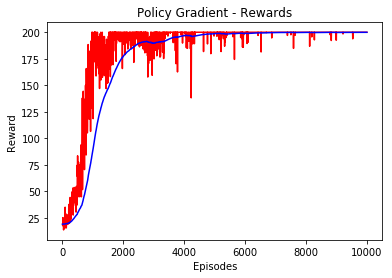

In [9]:
plt.plot(episodes,episodic_rewards,'r') # plotting t,a separately 
plt.plot(episodes,total_rewards,'b') # plotting t,b separately 
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Policy Gradient - Rewards')
plt.show()